In [1]:
import sys, torch

sys.path.append('tutorial_code')
if not torch.cuda.is_available():
    print("Change runtime type to include a GPU.")  

In [2]:
import logging
import os
import pathlib

import clip
import IPython.display
import numpy as np
import torch.nn.functional as F
import torchvision
import torch.hub
from netdissect import proggan
from PIL import Image
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader

sys.path.insert(0, "./CLIP_Steering")
try:
    import ganalyze_common_utils as common
    import ganalyze_transformations as transformations
except ImportError:
    print("Could not import ganalyze_common_utils or ganalyze_transformations")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Running pytorch', torch.__version__, 'using', device.type)

logging.basicConfig(
    format="%(asctime)s %(levelname)-8s %(message)s",
    level=logging.INFO,
    datefmt="%Y-%m-%d %H:%M:%S",
)

logger = logging.getLogger(__name__)

Running pytorch 1.9.1+cu111 using cuda


In [3]:
import torchvision
import torch.hub
from netdissect import nethook, proggan

#n = 'proggan_bedroom-d8a89ff1.pth'
# n = 'proggan_churchoutdoor-7e701dd5.pth'
# n = 'proggan_conferenceroom-21e85882.pth'
# n = 'proggan_diningroom-3aa0ab80.pth'
# n = 'proggan_kitchen-67f1e16c.pth'
n = 'proggan_livingroom-5ef336dd.pth'
# n = 'proggan_restaurant-b8578299.pth'

url = 'http://gandissect.csail.mit.edu/models/' + n
try:
    sd = torch.hub.load_state_dict_from_url(url) # pytorch 1.1
except:
    sd = torch.hub.model_zoo.load_url(url) # pytorch 1.0
proggan_model = proggan.from_state_dict(sd).to(device)
proggan_model

ProgressiveGenerator(
  (layer1): NormConvBlock(
    (norm): PixelNormLayer()
    (conv): Conv2d(512, 512, kernel_size=(4, 4), stride=(1, 1), padding=(3, 3), bias=False)
    (wscale): WScaleLayer()
    (relu): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer2): NormConvBlock(
    (norm): PixelNormLayer()
    (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (wscale): WScaleLayer()
    (relu): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer3): NormUpscaleConvBlock(
    (norm): PixelNormLayer()
    (up): DoubleResolutionLayer()
    (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (wscale): WScaleLayer()
    (relu): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer4): NormConvBlock(
    (norm): PixelNormLayer()
    (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (wscale): WScaleLayer()
    (relu): LeakyReLU(negative_slope=0.2, inplace=Tru

In [4]:
#@title Helper functions
from typing import List, Optional, Tuple
from PIL import Image


def show_images(
        images: list[Image.Image],
        resize: Optional[Tuple[int, int]] = None
    ):
    """Show a list of images in a row."""
    images = [np.array(img) for img in images]
    images = np.concatenate(images, axis=1)
    images = Image.fromarray(images)

    if resize:
        images.thumbnail(resize)

    IPython.display.display(images)


def show_and_save_images(
    images: list[Image.Image], batch: int, path: str, variant: str = "original"
):
    show_images(images)

    if not os.path.exists(path):
        os.makedirs(path)

    for i, img in enumerate(images):
        img.save(f"{path}/image_{batch}_{i}_{variant}.png")


def show_gan_results(gan_results: List[List[Tuple[Image.Image, np.ndarray]]]):
    for batch_results in gan_results:
        batch_size = len(batch_results[0][0])
      
        for i in range(batch_size):
            steering_images = [res[0][i] for res in batch_results]
            steering_scores = np.stack(
                [res[1][i].detach().cpu().numpy() for res in batch_results]
            ).tolist()
            print(steering_scores)
            show_images(steering_images, resize=(1024, 256))

def get_clip_probs(image_inputs, text_features, model, attribute_index=0):
    image_inputs = torch.stack([preprocess(img.resize((512, 512))) for img in image_inputs]).to(device)
    image_features = model.encode_image(image_inputs).float()

    # normalized features
    image_features = image_features / image_features.norm(dim=1, keepdim=True)
    text_features = text_features / text_features.norm(dim=1, keepdim=True)

    # cosine similarity as logits
    logit_scale = model.logit_scale.exp()
    logits_per_image = logit_scale * image_features @ text_features.t()

    clip_probs = logits_per_image.softmax(dim=-1)

    return clip_probs.narrow(dim=-1, start=attribute_index, length=1).squeeze(dim=-1)

def show_gan_results(gan_results: list):
    for batch_results in gan_results:
        batch_size = len(batch_results[0][0])
      
        for i in range(batch_size):
            steering_images = [res[0][i] for res in batch_results]
            steering_scores = np.stack(
                [res[1][i].detach().cpu().numpy() for res in batch_results]
            ).tolist()
            print(steering_scores)
            show_images(steering_images, resize=(1024, 256))


def make_images_and_probs(
    model, zdataset, clip_model, encoded_text, attribute_index=0
):
    gan_images = []
    for z in zdataset:
      gan_output = model(z[None,...])[0]      
      gan_images.append(renormalize.as_image(gan_output))
      
    clip_probs = get_clip_probs(gan_images, encoded_text, clip_model, attribute_index)

    return gan_images, clip_probs

In [5]:
from netdissect import zdataset,renormalize

SAMPLE_SIZE = 6 # Increase this for better results (but slower to run)
zds = zdataset.z_dataset_for_model(proggan_model, size=SAMPLE_SIZE, seed=5555)
latent_space_dim = zds[0][0][:,0,0].shape[0]

In [6]:
zds[0][0][None,...].shape

torch.Size([1, 512, 1, 1])

# Load the steering models and create steered noise

In [7]:
transformation_floral = transformations.OneDirection(latent_space_dim)
transformation_floral.load_state_dict(
    torch.load(
        "/home/ubuntu/GANSteering/proggan/pytorch_model_progran_steering_a floral bedroom_final.pth",
    ),
    strict=True,
)
transformation_floral.to(device)
transformation_floral.eval()


approach:  one_direction



OneDirection(
  (criterion): MSELoss()
)

In [8]:
alpha = 0.2
iters = 5
batch_size = 6

# Generate images by transforming the z vector in the positive direction
zds_dataloader = DataLoader(zds, batch_size=batch_size, shuffle=False)


with torch.no_grad():
    step_sizes = (
        (torch.ones((batch_size, latent_space_dim)) * alpha).float().to(device)
    )

    for zbatch in zds_dataloader:
        original_noise = zbatch[0].squeeze().to(device)
        floral_noise = original_noise.clone()

        for iter in range(iters):
            floral_noise = transformation_floral.transform(floral_noise, None, step_sizes)
            
        break

In [9]:
floral_noise = floral_noise[..., None, None]

In [19]:
original_noise = original_noise[..., None, None]

In [11]:
transformation_luxurious = transformations.OneDirection(latent_space_dim)
transformation_luxurious.load_state_dict(
    torch.load(
        "/home/ubuntu/GANSteering/proggan/pytorch_model_progran_steering_a luxurious bedroom_final.pth",
    ),
    strict=True,
)
transformation_luxurious.to(device)
transformation_luxurious.eval()


approach:  one_direction



OneDirection(
  (criterion): MSELoss()
)

In [12]:
alpha = 0.2
iters = 5
batch_size = 5

# Generate images by transforming the z vector in the positive direction
zds_dataloader = DataLoader(zds, batch_size=batch_size, shuffle=False)


with torch.no_grad():
    step_sizes = (
        (torch.ones((batch_size, latent_space_dim)) * alpha).float().to(device)
    )

    for zbatch in zds_dataloader:
        original_noise = zbatch[0].squeeze().to(device)
        luxurious_noise = original_noise.clone()

        for iter in range(iters):
            luxurious_noise = transformation_luxurious.transform(luxurious_noise, None, step_sizes)
            
        break

In [13]:
luxurious_noise = luxurious_noise[..., None, None]

# Hook the proggan

In [14]:
from netdissect import nethook
from netdissect import imgviz
from netdissect import show
from netdissect import tally
from netdissect import upsample
from netdissect import segviz

# Don't re-wrap it, if it's already wrapped (e.g., if you press enter twice)
if not isinstance(proggan_model, nethook.InstrumentedModel):
    proggan_model = nethook.InstrumentedModel(proggan_model)
proggan_model.retain_layer('layer4')

In [15]:
from netdissect import segmenter, setting

# segmodel = segmenter.UnifiedParsingSegmenter(segsizes=[256])
segmodel, seglabels, _ = setting.load_segmenter('netpq')
# seglabels = [l for l, c in segmodel.get_label_and_category_names()[0]]
print('segmenter has', len(seglabels), 'labels')

segmenter has 1813 labels


In [16]:
floral_img = proggan_model(floral_noise)
floral_acts = proggan_model.retained_layer('layer4')

In [17]:
luxurious_img = proggan_model(luxurious_noise)
luxurious_acts = proggan_model.retained_layer('layer4')

In [20]:

original_img = proggan_model(original_noise)
original_acts = proggan_model.retained_layer('layer4')

In [21]:
def find_activated_units(acts, threshold=0, image_num=None):
    n_images = acts.shape[0]
    n_units = acts.shape[1]
    unit_activation_shape = acts.shape[2] * acts.shape[3]
    if image_num is not None:
        activation = acts[image_num]
    else:
        print("Averaging all images")
        reshaped_tensor = acts.view(n_images, n_units, unit_activation_shape)
        activation = torch.mean(reshaped_tensor, dim=0)
    flattened_activation = activation.view(n_units, unit_activation_shape)

    # Find the indices of units with activation greater than the threshold
    unit_indices = torch.nonzero(torch.any(flattened_activation > threshold, dim=1), as_tuple=False)[:, 0]

    average_activations_filtered = torch.mean(flattened_activation[unit_indices], dim=1)

    sorted_unit_indices = torch.argsort(average_activations_filtered, descending=True)

    return sorted_unit_indices, average_activations_filtered

In [22]:
floral_activated_units, floral_activation_value = find_activated_units(floral_acts, threshold = 0,image_num = None)

Averaging all images


In [23]:
luxurious_activated_units, luxurious_activation_value = find_activated_units(luxurious_acts, threshold = 0,image_num = None)

Averaging all images


In [24]:
original_activated_units, original_activation_value = find_activated_units(original_acts, threshold = 0,image_num = None)

Averaging all images


In [38]:
def calculate_activation_difference(activated_units_1, average_activations_1, activated_units_2, average_activations_2):
    unit_indices = torch.unique(torch.cat((activated_units_1, activated_units_2))).tolist()
    activation_difference = []
    for unit in unit_indices:
        if unit in activated_units_1 and unit in activated_units_2:
            difference = torch.abs(average_activations_1[activated_units_1 == unit] - average_activations_2[activated_units_2 == unit])
        elif unit in activated_units_1:
            difference = average_activations_1[activated_units_1 == unit]
        elif unit in activated_units_2:
            difference = average_activations_2[activated_units_2 == unit]
        else:
            difference = torch.tensor(0.0)  # Convert to tensor for consistency
        activation_difference.append(difference.item())  # Convert to scalar value
    return unit_indices, activation_difference



In [39]:
unit_index, activation_difference =calculate_activation_difference(floral_activated_units, floral_activation_value,original_activated_units, original_activation_value)

In [40]:
import pandas as pd

upfn8 = upsample.upsampler((64, 64), (8, 8)) # layer4 is resolution 8x8

def compute_conditional_samples(zbatch):
    image_batch = proggan_model(zbatch.to(device))
    seg = segmodel.segment_batch(image_batch, downsample=4)
    upsampled_acts = upfn8(proggan_model.retained_layer('layer4'))
    return tally.conditional_samples(upsampled_acts, seg)

def find_semantic_concepts(activated_units, iou_table):
    semantic_concept = []
    semantic_conecpt_iou = []
    for u in activated_units:
        semantic_concept_index = torch.argmax(iou_table[u])
        iou = iou_table[u,semantic_concept_index ]
        semantic_concept.append(seglabels[semantic_concept_index])
        semantic_conecpt_iou.append(iou)
    return semantic_concept,semantic_conecpt_iou


def difference_dataframe(noise, threshold = 0, image_num = None):
    img = proggan_model(noise)
    acts = proggan_model.retained_layer('layer4')
    
    activated_units, activation_value = find_activated_units(acts, threshold = threshold,image_num = image_num)
    
    unit_index, activation_difference = calculate_activation_difference(activated_units, activation_value,original_activated_units, original_activation_value)
    
    cq = tally.tally_conditional_quantile(compute_conditional_samples, noise)
    iou_table = tally.iou_from_conditional_quantile(cq, cutoff=0.99) 
    associated_concepts, iou = find_semantic_concepts(unit_index, iou_table)
    
    data = {
        'Activation Difference': activation_difference,
        'Semantic Concept': associated_concepts,
        'IoU':  [float(tensor.item()) for tensor in iou]
    }

    df = pd.DataFrame(data, index=unit_index)
    df.index.name = 'Units'
    return df

In [41]:
floral_difference = difference_dataframe(floral_noise, 0, None)
floral_difference.head(10)

Averaging all images


  0%|          | 0/6 [00:00<?, ?it/s]

,Activation Difference,Semantic Concept,IoU
Units,,,
0,1.521838,armchair-b,0.108127
1,0.123962,shade,0.051386
2,1.176112,seat base,0.071379
3,0.196672,painting-t,0.077242
4,1.202921,wall-t,0.041338
5,1.406060,leather,0.093670
6,0.923395,sofa-t,0.117686
7,0.816053,back pillow,0.179069
8,0.053420,book-t,0.074019


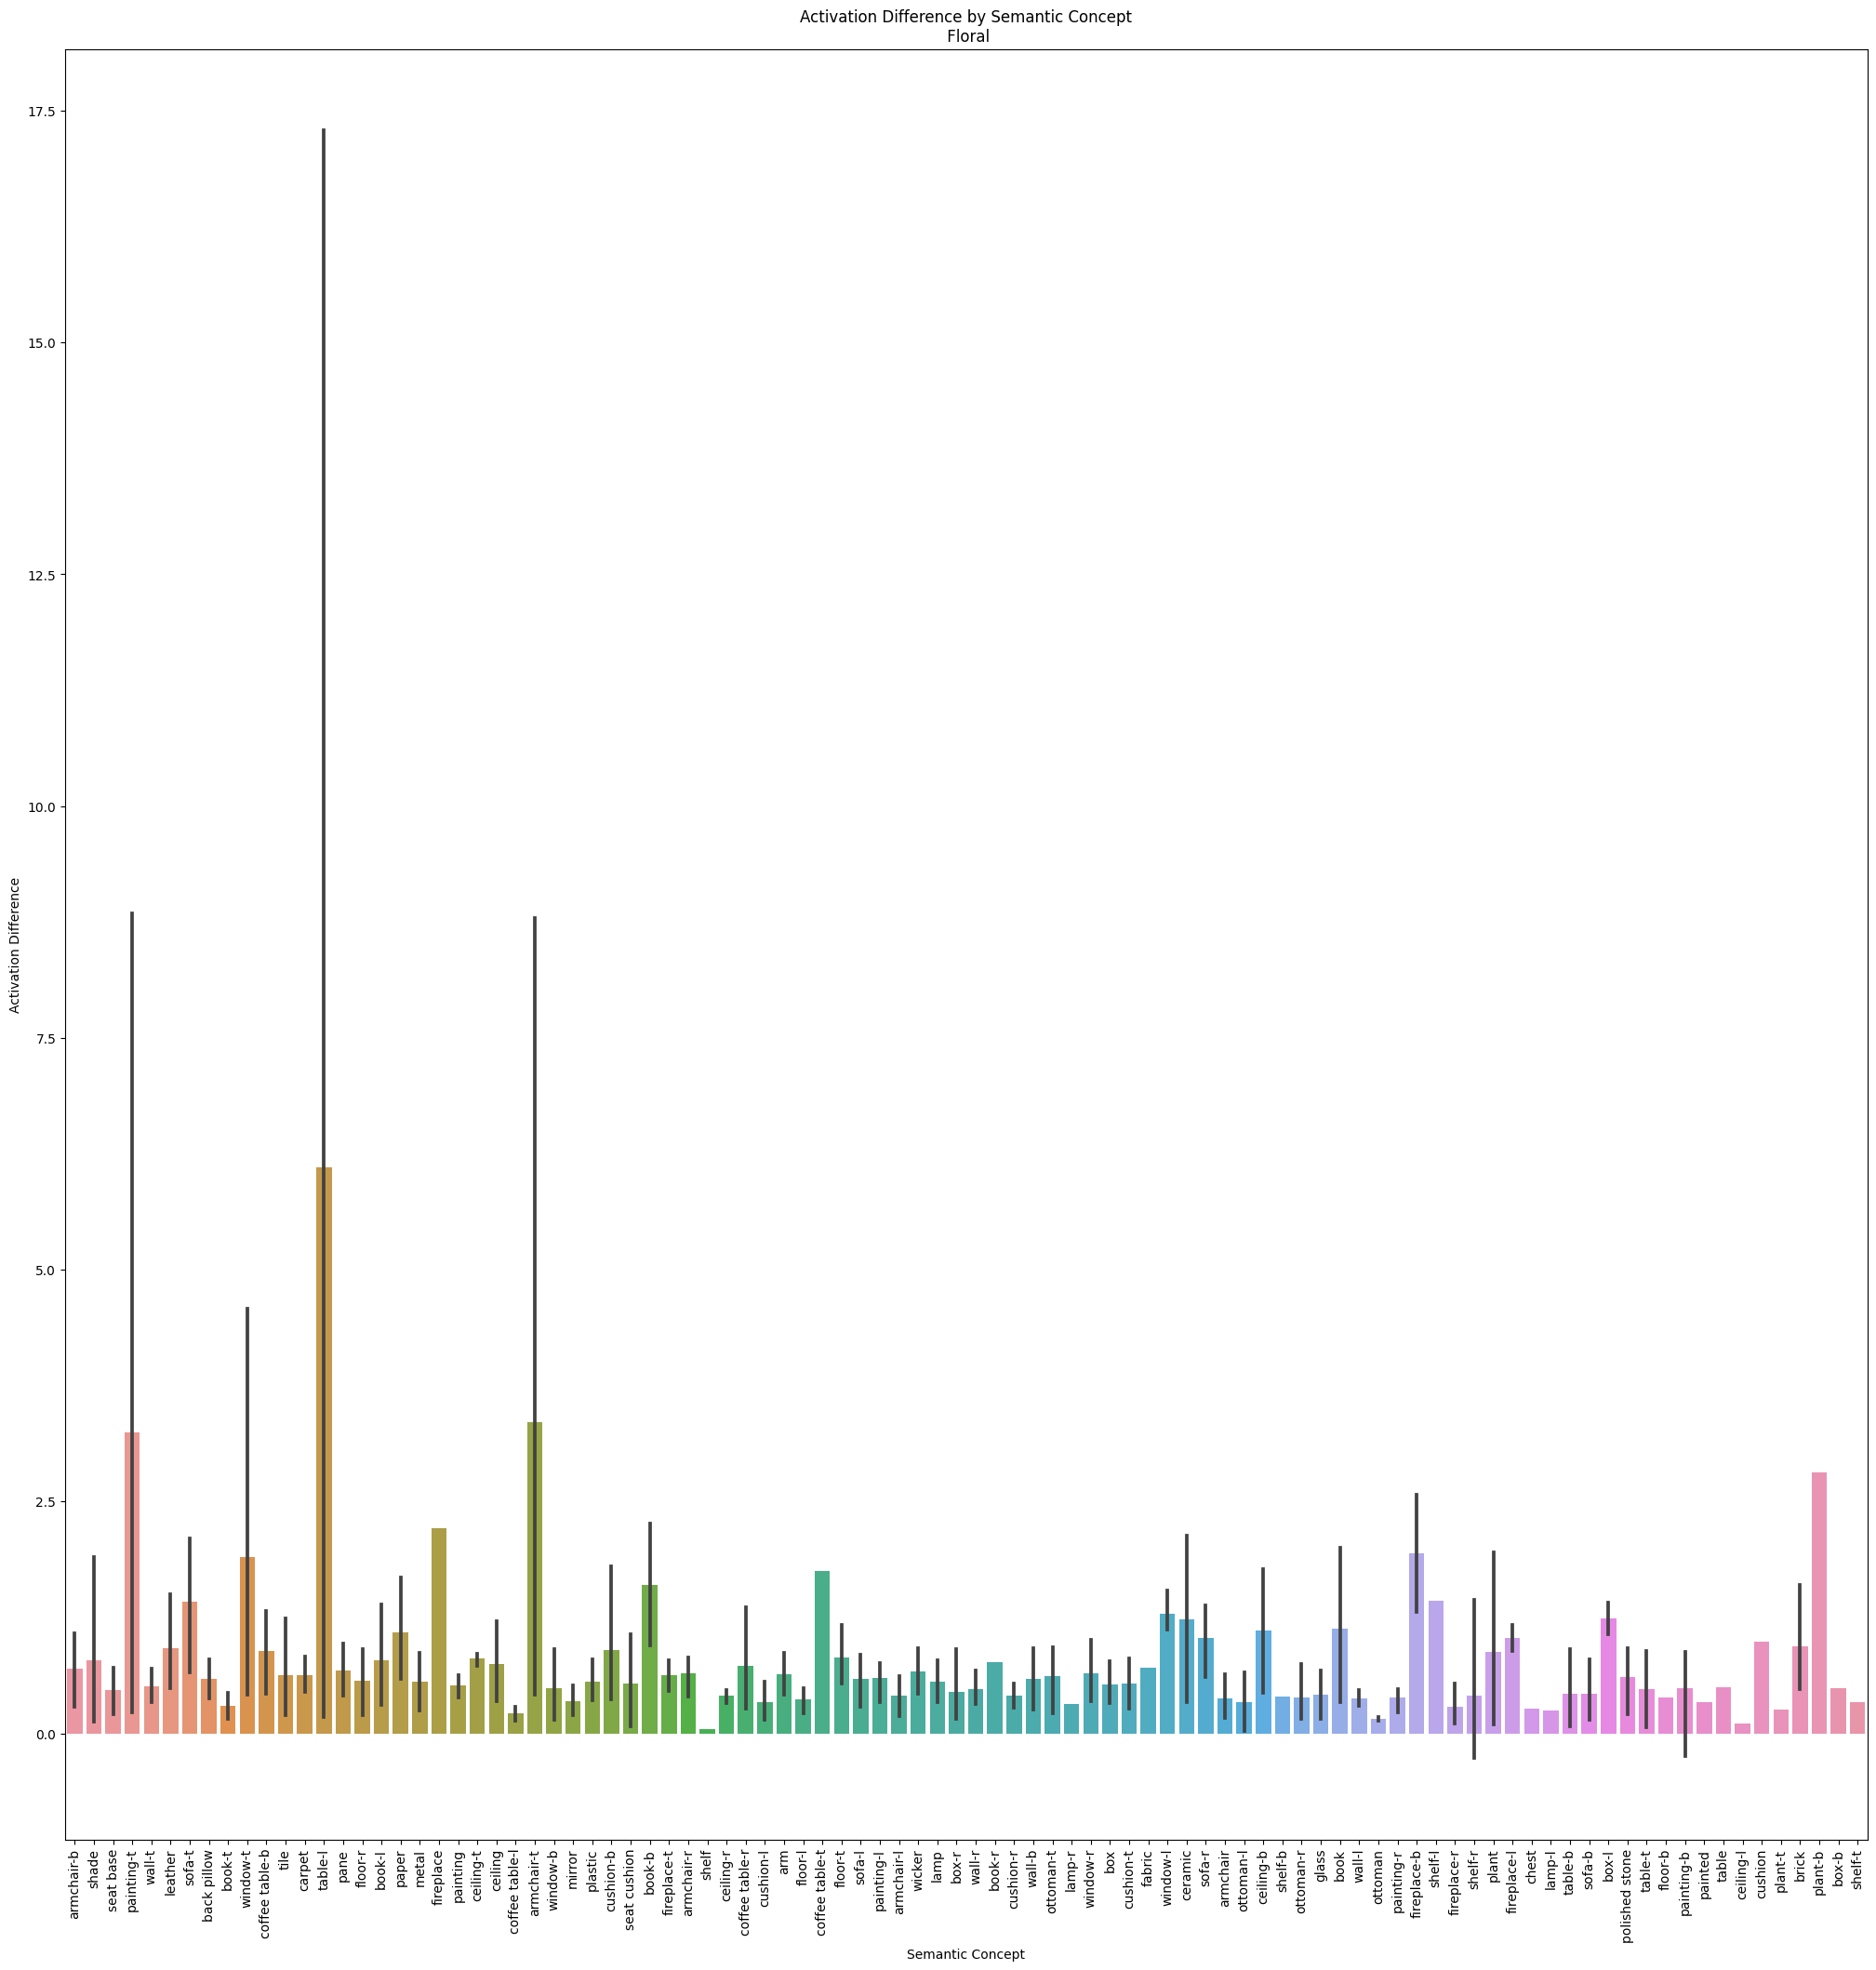

In [42]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(25, 25))
sns.barplot(x='Semantic Concept', y='Activation Difference', data=floral_difference[floral_difference['IoU'] > 0])
plt.xlabel('Semantic Concept')
plt.ylabel('Activation Difference')
plt.title('Activation Difference by Semantic Concept\n Floral')
plt.xticks(rotation=90)
plt.show()

In [32]:
floral_activation_dif = floral_difference.groupby('Semantic Concept')['Activation Difference'].mean()

floral_average_iou = floral_difference.groupby('Semantic Concept')['IoU'].mean()

floral_result = floral_activation_dif.to_frame().join(floral_average_iou)

floral_result.columns = ['Activation Difference Average', 'Average IoU']

floral_result.sort_values(by="Activation Difference Average", ascending = False).head(10)

,Activation Difference Average,Average IoU
Semantic Concept,,
painting-t,3.817668,0.045872
fireplace,2.208695,0.248148
coffee table-t,1.747776,0.093306
window-t,1.624358,0.087460
brick,0.938104,0.065476
ceramic,0.894870,0.089797
fabric,0.712083,0.025702
sofa-r,0.704962,0.079244
ceiling-b,0.664635,0.118342


In [43]:
luxurious_difference = difference_dataframe(luxurious_noise, 0, None)
luxurious_difference.head(10)

Averaging all images


  0%|          | 0/5 [00:00<?, ?it/s]

,Activation Difference,Semantic Concept,IoU
Units,,,
0,1.065832,sofa-b,0.110642
1,0.180268,table-b,0.123555
2,0.502684,seat cushion,0.116562
3,0.849592,wall-t,0.041821
4,0.453731,coffee table-t,0.060061
5,0.293755,mirror,0.149062
6,1.101636,brick,0.126268
7,0.080157,floor-t,0.115590
8,0.709986,window-l,0.054638


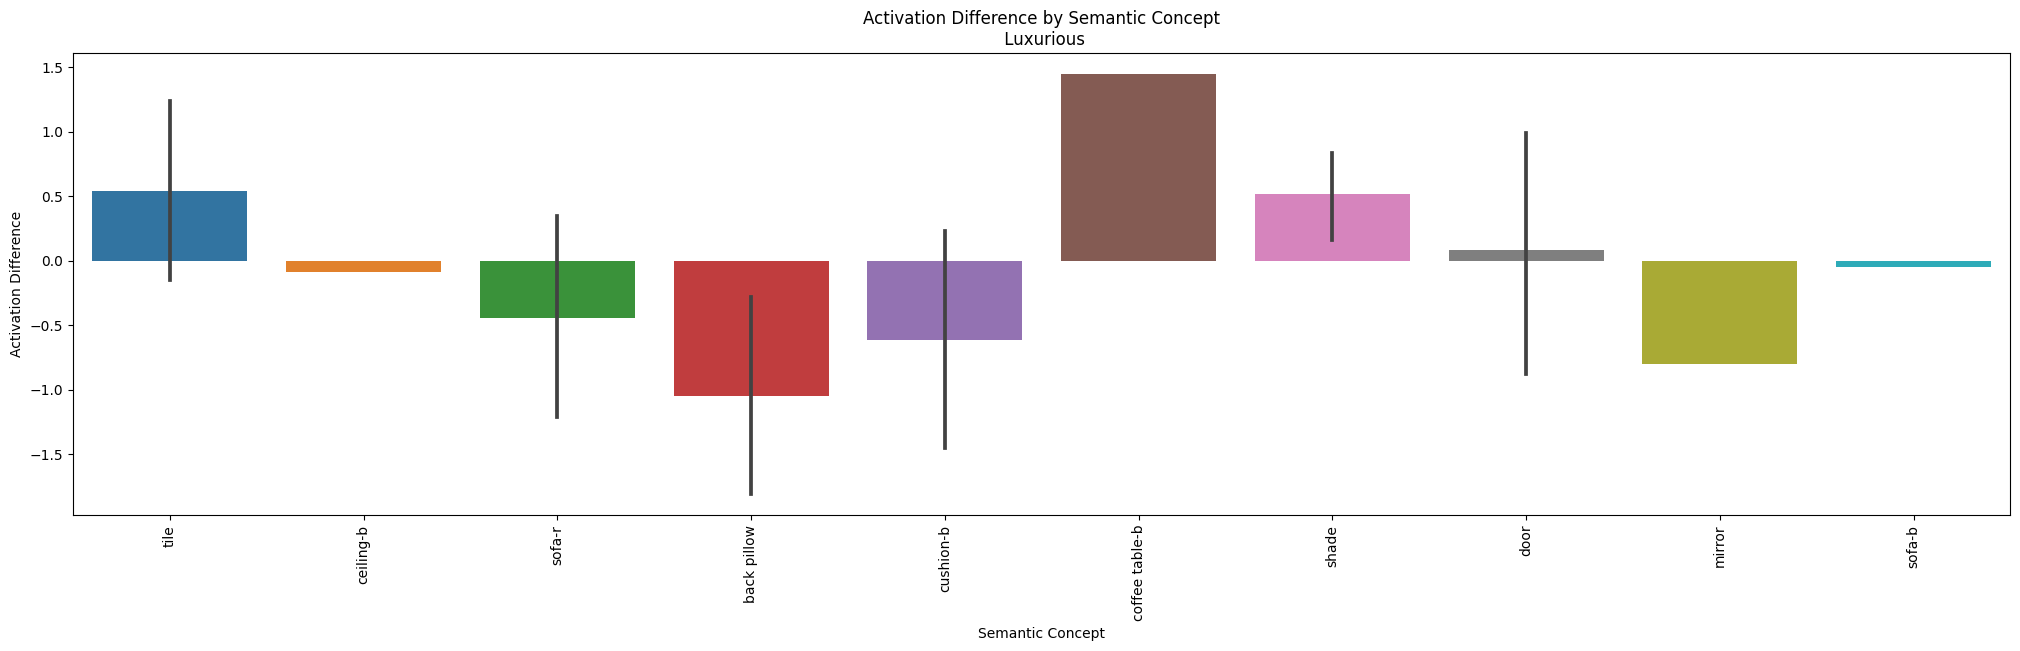

In [34]:
plt.figure(figsize=(25, 6))
sns.barplot(x='Semantic Concept', y='Activation Difference', data=luxurious_difference[luxurious_difference['IoU'] > 0.25])
plt.xlabel('Semantic Concept')
plt.ylabel('Activation Difference')
plt.title('Activation Difference by Semantic Concept\n Luxurious')
plt.xticks(rotation=90)
plt.show()

In [35]:
luxurious_activation_dif = luxurious_difference.groupby('Semantic Concept')['Activation Difference'].mean()

fluxurious_average_iou = luxurious_difference.groupby('Semantic Concept')['IoU'].mean()

luxurious_result = luxurious_activation_dif.to_frame().join(fluxurious_average_iou)

luxurious_result.columns = ['Activation Difference Average', 'Average IoU']

luxurious_result.sort_values(by="Activation Difference Average", ascending = False).head(10)

,Activation Difference Average,Average IoU
Semantic Concept,,
plant-r,5.377806,0.114256
screen,2.173717,0.106964
cushion-b,1.702710,0.206317
chair,1.460908,0.081686
plant-l,1.196618,0.154783
ceramic,0.684096,0.101261
coffee table-l,0.642716,0.126794
leg,0.594767,0.061747
ceiling-b,0.588427,0.134157


## Compare luxurious vs floral

In [44]:
# Group the luxurious and floral dataframes by 'Semantic Concept' and calculate the mean of 'Activation Difference'
luxurious_grouped = luxurious_difference.groupby('Semantic Concept')['Activation Difference'].mean()
floral_grouped = floral_difference.groupby('Semantic Concept')['Activation Difference'].mean()

# Merge the grouped dataframes on the 'Semantic Concept' index
merged_df = pd.merge(luxurious_grouped, floral_grouped, left_index=True, right_index=True, suffixes=['_Luxurious', '_Floral'])

merged_df.head()

,Activation Difference_Luxurious,Activation Difference_Floral
Semantic Concept,,
arm,0.319146,0.637141
armchair-b,0.373667,0.696241
armchair-l,0.686863,0.409853
armchair-r,0.592212,0.649098
armchair-t,0.523284,3.358736


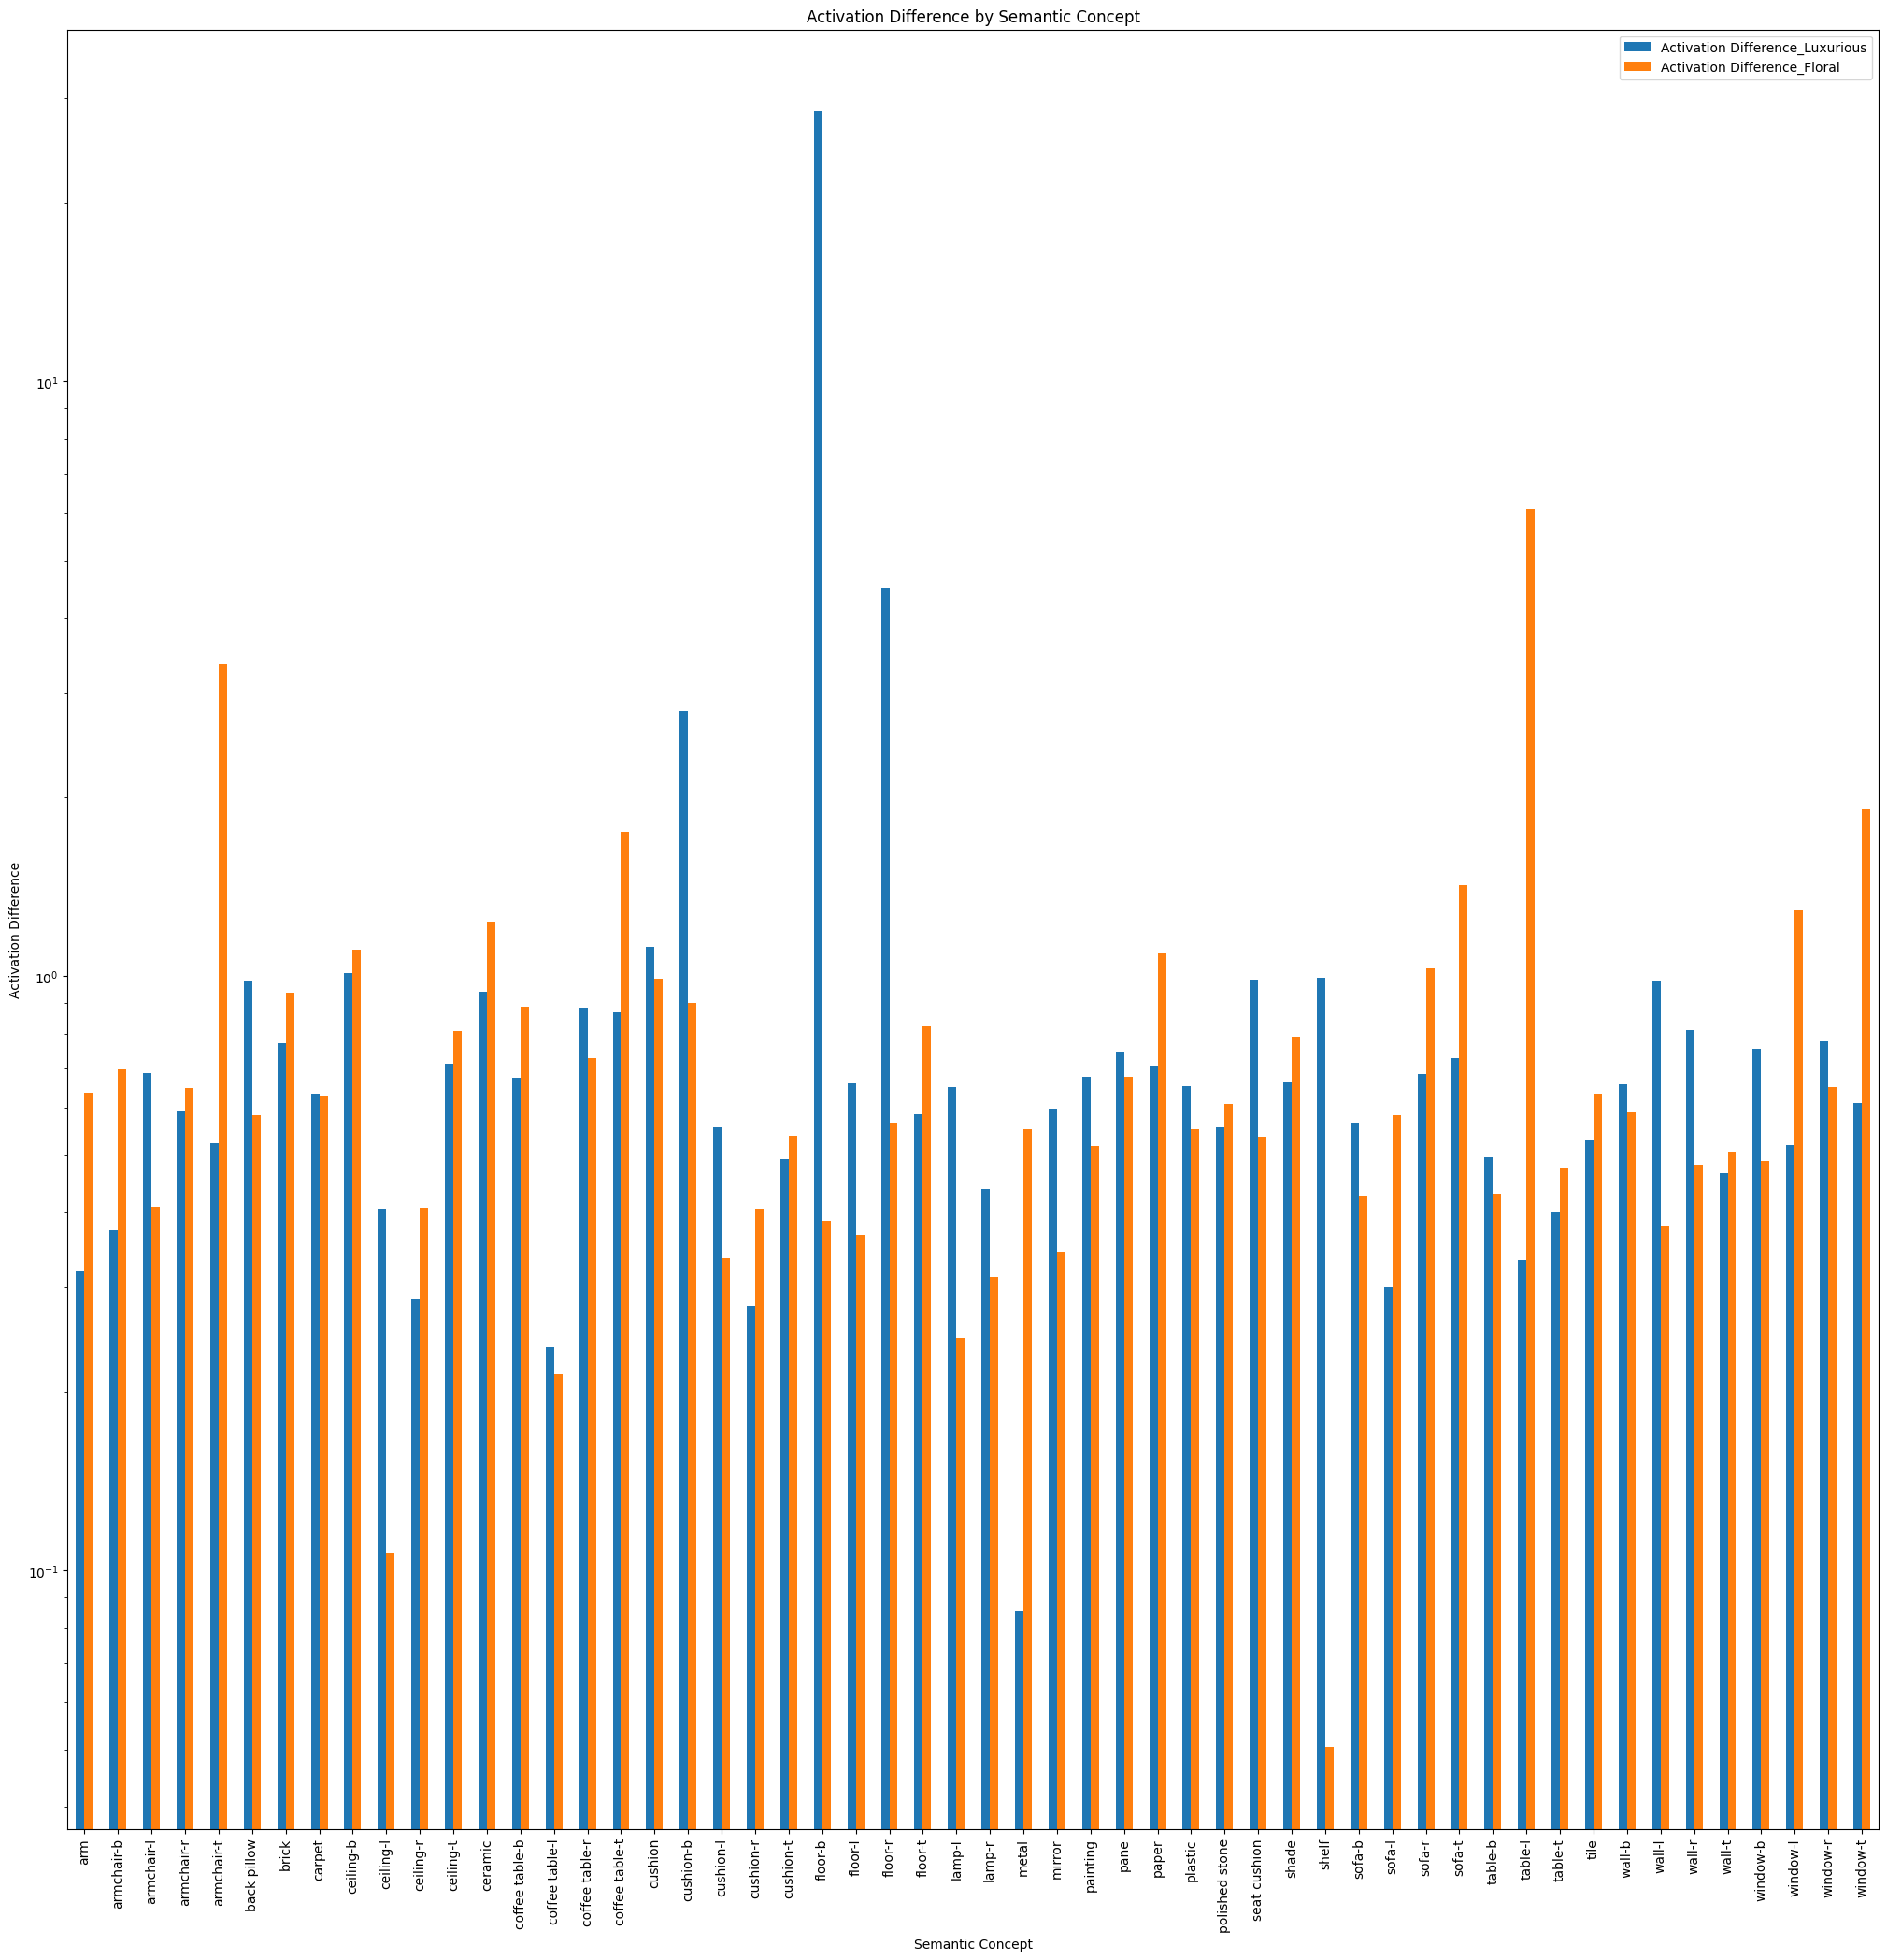

In [46]:
import matplotlib.pyplot as plt

# Plot the activation difference for each semantic concept
merged_df.plot(kind='bar', figsize=(25, 25))

# Set the plot title and labels
plt.title('Activation Difference by Semantic Concept')
plt.xlabel('Semantic Concept')
plt.ylabel('Activation Difference')

plt.yscale('log')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.show()
